This notebook demonstrates how a DAG can be used in combination with the assignment of a distribution to each node and a weight to each edge to create a linear SCM.

In [1]:
import sys
import time

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from y0.graph import NxMixedGraph
from y0.dsl import V1, V2, V3, V4, V5, V6
from y0.simulation import simulate, example_graph, example_generators

In [2]:
print(sys.version)

3.11.6 (main, Oct  2 2023, 13:45:54) [Clang 15.0.0 (clang-1500.0.40.1)]


In [3]:
print(time.asctime())

Tue Feb  6 14:33:29 2024


In [4]:
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats("svg")

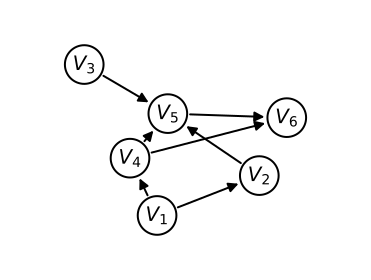

In [5]:
example_graph.draw(prog="neato")

In [6]:
example_graph.to_linear_scm_latex()

'\\begin{align*}V_1 &= \\epsilon_{V_1} \\\\\n V_3 &= \\epsilon_{V_3} \\\\\n V_2 &= V_{1} \\beta_{V_1,V_2} + \\epsilon_{V_2} \\\\\n V_4 &= V_{1} \\beta_{V_1,V_4} + \\epsilon_{V_4} \\\\\n V_5 &= V_{2} \\beta_{V_2,V_5} + V_{3} \\beta_{V_3,V_5} + V_{4} \\beta_{V_4,V_5} + \\epsilon_{V_5} \\\\\n V_6 &= V_{4} \\beta_{V_4,V_6} + V_{5} \\beta_{V_5,V_6} + \\epsilon_{V_6} \\\\\\end{align*}'

## Simulating Data

It's possible to simulate data using a linear structural causal model (SCM) given the following:

1. A directed acyclic graph (DAG) structure
2. A scalar weight for each edge in the DAG
3. A probability distribution for each node

In [7]:
df, fits = simulate(example_graph, generators=example_generators, trials=5000)

Simulation:   0%|          | 0.00/5.00k [00:00<?, ?trial/s]

Ultimately the simulation provides _trials_ number of data points:

In [8]:
df

,V1,V3,V2,V4,V5,V6
0,-0.873840,0.782007,0.637107,-0.498464,1.012664,-1.000228
1,-0.587852,-0.145067,-0.153720,1.252619,0.033209,-1.200001
2,0.298335,-0.669625,-0.699946,-6.002474,-5.932881,0.660224
3,0.629162,0.400040,1.355679,-2.131465,1.628208,-2.607022
4,-0.243863,1.074162,1.498635,-1.222608,2.191341,3.219852
...,...,...,...,...,...,...
4995,0.121080,0.007366,1.142377,-0.423337,0.329853,-1.230234
4996,0.525196,0.758623,1.404291,3.784929,0.794943,0.943836
4997,0.534148,-1.191449,1.097434,0.354537,2.528142,-2.752115
4998,-0.250800,-1.497609,-0.489547,2.518973,2.630942,-0.465015


The simulation also performs several calculations over each pair of variables:

1. What's the correlation coefficient ($r^2$) between the variables?
2. Are the variables d-separated (i.e., conditionally independent)?

In [9]:
param_df = pd.DataFrame(
    [
        (
            a.name,
            b.name,
            t.slope,
            t.intercept,
            t.r2,
            # t.edge,
            False if t.d_separation is None else t.d_separation.separated,
            None if t.d_separation is None else t.d_separation.conditions,
        )
        for (a, b), t in fits.items()
    ],
    columns=[
        "parent",
        "child",
        "slope",
        "intercept",
        "r2",
        "d_separated",
        "d_sep_cond",
    ],
)
param_df

,parent,child,slope,intercept,r2,d_separated,d_sep_cond
0,V1,V2,0.921780,0.002188,0.174278,False,None
1,V4,V1,0.431604,0.000405,0.015031,False,None
2,V5,V2,0.138432,-0.004329,0.006130,False,None
3,V4,V5,0.683676,-0.002904,0.380053,False,None
4,V6,V4,0.667638,0.039908,0.167590,False,None
5,V6,V5,0.384221,0.039729,0.068263,False,None
6,V5,V3,0.373807,-0.000903,0.027927,False,None
7,V1,V3,-0.006219,-0.011256,0.000013,True,()
8,V1,V5,0.361803,-0.002070,0.008588,True,"(V2, V4)"
9,V6,V1,0.209904,0.039525,0.001337,True,"(V4, V5)"


The following plot demonstrates that variables that are d-separated (i.e., conditionally independent) have effectively no correlation.

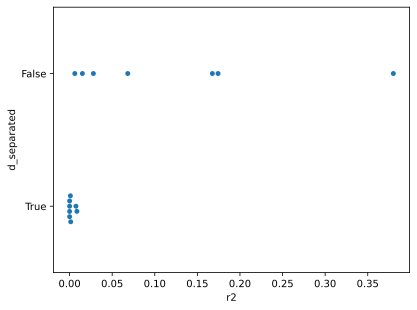

In [10]:
sns.swarmplot(data=param_df, y="d_separated", x="r2", orient="h")
plt.show()